Data Preprocessing

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def parse_annotation(annotation_line):
    parts = annotation_line.strip().split()
    class_id = int(parts[0])  # The class_id is the first element
    vertices = np.array(parts[1:], dtype=np.float32)  # The rest are the vertices
    return class_id, vertices.reshape((-1, 2))  # Reshape to Nx2 where N is the number of vertices

def draw_polygon_on_mask(mask, corners, image_shape):
    scaled_corners = corners * np.array([image_shape[1], image_shape[0]], dtype=np.float32)  # scale x and y
    scaled_corners = np.around(scaled_corners).astype(np.int32)  # round and convert to int

    # print("Scaled Corners:", scaled_corners)  # Debugging print

    corners_int = scaled_corners.reshape((-1, 1, 2))
    cv2.fillPoly(mask, [corners_int], color=(255))  # Ensure fillPoly is used, not polylines

    # # Debugging visualization
    # plt.imshow(mask, cmap='gray')
    # plt.title('Polygon on Mask')
    # plt.axis('off')
    # plt.show()

def create_mask_from_annotations(annotation_path, image_shape):
    mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)  # Create a black mask
    with open(annotation_path, 'r') as file:
        for line in file:
            class_id, vertices = parse_annotation(line)
            draw_polygon_on_mask(mask, vertices, image_shape)  # Draw each polygon on the mask
    return mask

def preprocess_image(image_path, annotation_path, target_size):
    # Open and resize image
    image = Image.open(image_path).resize(target_size)
    mask = create_mask_from_annotations(annotation_path, target_size)  # Note the reversal of width and height for the mask
    return np.array(image), mask

def process_directory(data_dir, annotation_dir, target_size):
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            image, mask = preprocess_image(image_path, annotation_path, target_size)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy')), image)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy')), mask)
            # plt.imshow(mask, cmap='gray')  # Debugging visualization
            # plt.show()
            
def save_as_npy(data_dir, annotation_dir, target_size=(512, 512)):
    processed_data = []
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            image, mask = preprocess_image(image_path, annotation_path, target_size)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy')), image)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy')), mask)
            processed_data.append((image, mask))
    print(f"Processed and saved {len(processed_data)} image-mask pairs in .npy format.")

# Example usage
dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (512, 512)  # Change as required by your model

# Process images and annotations and save them as .npy files
# Process images and annotations
for part in partitions:
    images_dir = os.path.join(dataset_base, part, 'images')
    annotations_dir = os.path.join(dataset_base, part, 'labels')
    process_directory(images_dir, annotations_dir, target_size)
    print(f"Finished processing {part} set")

# Visualization (example for one image from the 'train' set)
train_images_dir = os.path.join(dataset_base, 'train', 'images')
train_image_files = [f for f in os.listdir(train_images_dir) if f.endswith('_img.npy')]

# Load one image and its corresponding mask
image = np.load(os.path.join(train_images_dir, train_image_files[0]))
mask = np.load(os.path.join(train_images_dir, train_image_files[0].replace('_img.npy', '_mask.npy')))

# # Visualize the image and the mask
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title('Processed Image')
# plt.axis('off')
# 
# plt.subplot(1, 2, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Processed Mask')
# plt.axis('off')
# 
# plt.show()



Finished processing train set
Finished processing valid set
Finished processing test set


Semantics CNN

Found 8691 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\train\images
Found 2483 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\valid\images
Found 1242 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\test\images
Epoch [1/10], Train Loss: 0.3540, Valid Loss: 0.4087
Epoch [2/10], Train Loss: 0.3255, Valid Loss: 0.3275
Epoch [3/10], Train Loss: 0.2703, Valid Loss: 0.2698
Epoch [4/10], Train Loss: 0.2725, Valid Loss: 0.2457
Epoch [5/10], Train Loss: 0.1600, Valid Loss: 0.2202
Epoch [6/10], Train Loss: 0.1958, Valid Loss: 0.2074
Epoch [7/10], Train Loss: 0.1423, Valid Loss: 0.1761
Epoch [8/10], Train Loss: 0.1478, Valid Loss: 0.1827
Epoch [9/10], Train Loss: 0.1517, Valid Loss: 0.1645
Epoch [10/10], Train Loss: 0.1841, Valid Loss: 0.1643

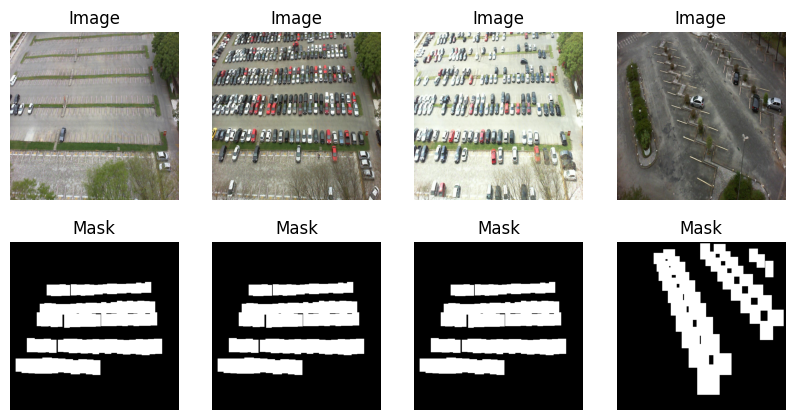

In [7]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

# Define the CNN architecture for segmentation
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid for binary segmentation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")  # Debugging output

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (45, 45)


# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

    print(f'Epoch [{epoch+1}/10], Train Loss: {loss.item():.4f}, Valid Loss: {val_loss/len(valid_loader):.4f}')

# Visualization
images, masks = next(iter(train_loader))
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')
plt.show()


In [74]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set the base directory where the train, valid, and test folders are located
base_dir = r'C:/Users/SirM/Downloads/PKLot.v1-raw.voc'

# Define the desired image shape
desired_shape = (45, 45)  # Example size, adjust as needed

# Function to parse XML annotation and create a binary mask
def parse_annotation(xml_path, img_shape):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Initialize a mask with zeros
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    
    # Extract bounding boxes and set corresponding mask regions to 1
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        mask[ymin:ymax, xmin:xmax] = 1  # Mark occupied spaces as 1
    
    return mask

# Function to load images and corresponding annotations
def load_images_and_masks(data_dir, desired_shape):
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    images = []
    masks = []
    
    for image_file in image_files:
        # Load image
        img_path = os.path.join(data_dir, image_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, desired_shape[::-1])  # OpenCV expects width x height
        img = img / 255.0  # Normalize image pixels to [0, 1]
        
        # Load corresponding annotation
        xml_file = image_file.replace('.jpg', '.xml')
        xml_path = os.path.join(data_dir, xml_file)
        mask = parse_annotation(xml_path, img.shape)
        mask = cv2.resize(mask, desired_shape[::-1])  # Resize mask like the image
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

# Preprocess each dataset
train_images, train_masks = load_images_and_masks(os.path.join(base_dir, 'train'), desired_shape)
valid_images, valid_masks = load_images_and_masks(os.path.join(base_dir, 'valid'), desired_shape)
test_images, test_masks = load_images_and_masks(os.path.join(base_dir, 'test'), desired_shape)

class ParkingLotDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def transform(self, image, mask):
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask).float()
        return image, mask

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        
        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.images)
    
    def transform(self, image, mask):
        image = TF.to_tensor(image).float()  # Convert image to float32 tensor
        mask = TF.to_tensor(mask).float()    # Convert mask to float32 tensor
        return image, mask
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        # ... add more layers as needed
        self.decoder1 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # ... add more layers as needed
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)
        # ... continue forward pass
        # Decoder
        x = self.up1(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.decoder1(x)
        # ... continue forward pass
        x = self.final_conv(x)
        return torch.sigmoid(x)

model = UNet().to(device)

# Create Dataset and DataLoader for train and validation sets
train_dataset = ParkingLotDataset(train_images, train_masks)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

valid_dataset = ParkingLotDataset(valid_images, valid_masks)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Setup the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, masks in dataloader:
            images = images.to(device).float()  # Ensure images are on GPU as float32
            masks = masks.to(device).float()    # Ensure masks are on GPU as float32

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        # Print epoch loss
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}')


# Start training
num_epochs = 25
train(model, train_loader, criterion, optimizer, num_epochs, device)

def evaluate_accuracy(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            predicted = outputs > 0.5
            total += masks.numel()
            correct += (predicted == masks).sum().item()
    return correct / total

# Calculate accuracy on validation set
accuracy = evaluate_accuracy(model, valid_loader,device)
print(f'Validation Accuracy: {accuracy:.4f}')

cuda


RuntimeError: Given transposed=1, weight of size [256, 128, 2, 2], expected input[8, 128, 11, 11] to have 256 channels, but got 128 channels instead